In [ ]:
!pip install requests

import requests
import pandas as pd
from datetime import datetime, timedelta
import json
import os
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
import matplotlib.pyplot as plt
!pip install wordcloud
from wordcloud import WordCloud
from collections import Counter
import time
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Article Fetching Cell

today = datetime.utcnow().date()
start_date = (today - timedelta (days=30)).isoformat()
end_date = today.isoformat()

API_KEY = os.getenv("NEWSAPI_KEY", "MISSING_KEY")

# Defines the endpoint and parameters
url = "https://newsapi.org/v2/everything"

test_mode = True
per_language_limit = 2 if test_mode else 40
max_pages = 1 if test_mode else 5

languages = ["en", "de"]
all_articles = []

keywords = [
    "Austria", "Austrian", "Vienna", "EU policy", "climate action",
    "social justice", "environmental policy", "energy transition",
    "migration Europe", "social impact", "climate impact", "policy impact",
    "environmental impact", "impact maker", "policy maker", "impact hub",
    "sustainable business", "new business", "innovation", "policy innovation"
    "climate innovation", "business innovation", "waste", "impact community",
    "community", "just policy", "social entrepreneurs", "entrepreneurs",
    "sustainable entrepreneurs", "sustainable entrepreneurship", "social entrepreneurship",
    "sustainable world", "world policy", "world climate", "world", "sustainable food", "community work",
    "social change", "environmental change", "policy change", "social support", "environmental support",
    "start ups", "start up", "start-ups", "start-up", "innovative start-up", "innovative start-ups",
    "innovative start up", "innovative start ups", "need support", "climate need", "teamwork", "women",
    "impactful women", "innovative women", "powerful women", "future climate", "sustainablity", "energy use",
    "energy usage", "women of the year", "energy policy"
]

query_string = " OR ".join([f"\"{word}\"" if " " in word else word for word in keywords])

def chunk_keywords(keywords, max_chars=500):
  chunks = []
  current = []

  for word in keywords:
    formatted = f"\"{words}\"" if " " in word else word
    test_chunk = current + [formatted]
    test_string = " OR ".join(test_chunk)
    if len(test_string) <= max_chars:
      current = test_chunk
    else:
      chunks.append(" OR ".join(current))
      current = [formatted]

    if current:
      chunks.append(" OR ".join(current))

    return chunks

query_chunks = chunk_keywords(keywords)

for lang in languages:
  print(f"\nFetching articles for language: {lang}")
  page = 1

  for query_string in query_chunks:
    page = 1

  while True:
    params = {
    "q": query_string,
    "language": lang,
    "sortBy": "publishedAt",
    "pageSize": per_language_limit,
    "from": start_date,
    "to": end_date,
    "page":page,
    "apiKey": API_KEY,
    }

    response = requests.get(url, params=params)
    data = response.json()

    if response.status_code != 200:
      print(f"Error fetching page {page} for {lang}: {data.get('message', 'Unknown error')}")
      break

    articles = data.get("articles", [])

    #Adding language tag to each article
    for article in articles:
      article["language"] = lang
    all_articles.extend(articles)

    print(f"Fetched {len(articles)} articles on page {page} for {lang} (Total so far: {len(all_articles)})")

    if len(articles) < per_language_limit or page >= max_pages:
      break #stop if less than a full page returned or reached max pages in test mode
    else:
      page += 1 #goes to next page
      time.sleep(1) #delays requests to avoid slamming NewsAPI with requests

  print(f"\nDone fetching. Total articles collected: {len(all_articles)}")


Fetching articles for language: en
Fetched 2 articles on page 1 for en (Total so far: 2)

Done fetching. Total articles collected: 2

Fetching articles for language: de
Fetched 2 articles on page 1 for de (Total so far: 4)

Done fetching. Total articles collected: 4


In [ ]:
#Deduplication of same articles translated in English and German
seen_titles = set()
unique_articles = []

for article in all_articles:
  title = article.get("title", "")
  language = article.get("language", "")
  if not title:
    continue # skips articles with no title

  title_key = f"{title}_{language}".lower().strip()

  if title_key not in seen_titles:
    seen_titles.add(title_key)
    unique_articles.append(article)

print(f"Deduplicated articles. Total unique articles: {len(unique_articles)}")

Deduplicated articles. Total unique articles: 4


In [ ]:
#Improved Preprocessing

stop_words = set(stopwords.words('english')) | set(stopwords.words('german'))

processed_texts = []
final_articles = [] #articles that pass preprocessing

for article in unique_articles:
  title = article.get("title", "")
  description = article.get('description', "")
  content = article.get("content", "")

  text = f"{title} {description} {content}".lower()
  text = re.sub(r'\d+', ' ', text) #removes numbers
  text = re.sub(r'\s+', ' ', text) #collapse whitespace
  text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]', '', text) #keep only letters & German umlauts
  text = text.strip()

  #Tookenize & remove stopwords

  words = text.split()
  words = [word for word in words if word not in stop_words]

  cleaned_text = ' '.join(words)

  #Only keep articles with meaningful length

  if len(cleaned_text.split()) > 5:
    processed_texts.append(cleaned_text)
    final_articles.append(article) #match cleaned text to original article

print(f"Preprocessing complete. {len(processed_texts)} articles ready for clustering.")

Preprocessing complete. 4 articles ready for clustering.


In [ ]:
vectorizer = TfidfVectorizer(
    stop_words=list(stop_words),
    lowercase=True,
    max_df=0.8, #removes very common words
    min_df=1 if test_mode else 2, #removes very rare words
    ngram_range=(1,2), #unigrams & bigrams
    max_features=5000 #optional: limites features for Colab safety
)

X = vectorizer.fit_transform(processed_texts)

print(f"TF-IDF vectorization complete. Shape of matrix: {X.shape}")

TF-IDF vectorization complete. Shape of matrix: (4, 277)


In [ ]:
#KMeans clustering for articles
k = min(5, X.shape[0]) #Don't allow more clusters than articles

kmeans = KMeans(n_clusters=k, random_state=42)
article_clusters = kmeans.fit_predict(X)

for i, article in enumerate(final_articles):
  article['cluster'] = article_clusters[i]

print(f"KMeans clustering complete. {k} clusters created.")

feature_names = vectorizer.get_feature_names_out()

cluster_labels = {}

for i in range (k):
  cluster_indices = [idx for idx, article in enumerate(final_articles) if article['cluster'] == i]

  if not cluster_indices:
    continue #skips empty clusters

  #Subset TF-IDF scores across all articles in this cluster
  cluster_matrix = X[cluster_indices]

  #Average TF-IDF scores across all articles in this cluster
  mean_tfidf = cluster_matrix.mean(axis=0).A1 #converts sparse matric to 1D array

  #Get top 5 words for this cluster
  top_indices = mean_tfidf.argsort()[::-1][:5]
  top_terms = [feature_names[idx] for idx in top_indices]

  label = ", ".join(top_terms)
  cluster_labels[i] = {
      'top_terms': top_terms,
      'label': label,
      'custom_label': f"Cluster {i}"
  }

for cid, info in cluster_labels.items():
  print(f"\n Cluster {cid} Summary:")
  print("Top Terms:", info['top_terms'])
  print("Suggested Label:", info['custom_label'])

KMeans clustering complete. 4 clusters created.

 Cluster 0 Summary:
Top Terms: ['book', 'without', 'without outline', 'outline', 'nonfiction']
Suggested Label: Cluster 0

 Cluster 1 Summary:
Top Terms: ['prozent', 'zahl', 'tourismus', 'österreich gemacht', 'beherbergung gastronomie']
Suggested Label: Cluster 1

 Cluster 2 Summary:
Top Terms: ['finneas', 'love', 'offscreen', 'director offscreen', 'hudson']
Suggested Label: Cluster 2

 Cluster 3 Summary:
Top Terms: ['abgegeben', 'füchse', 'tierheim', 'zwei', 'abgegeben zwei']
Suggested Label: Cluster 3


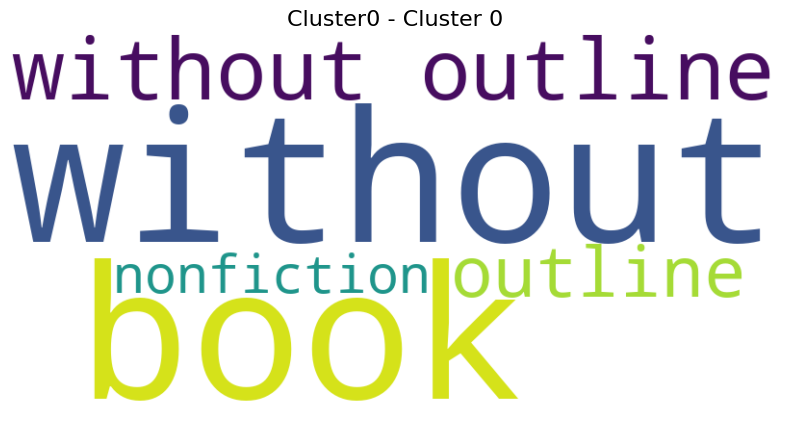

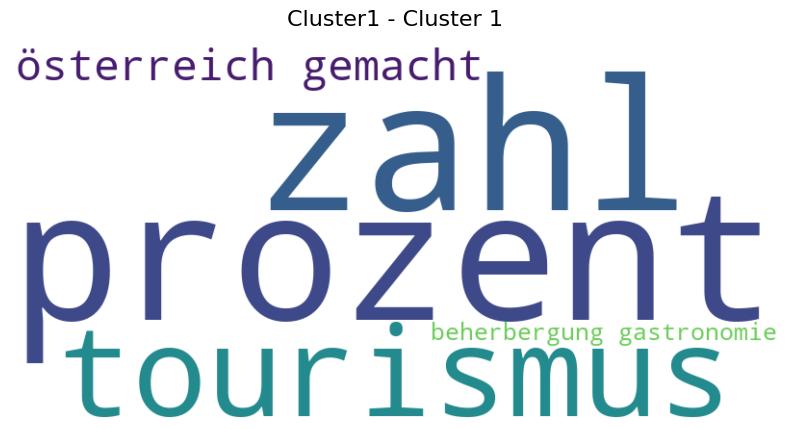

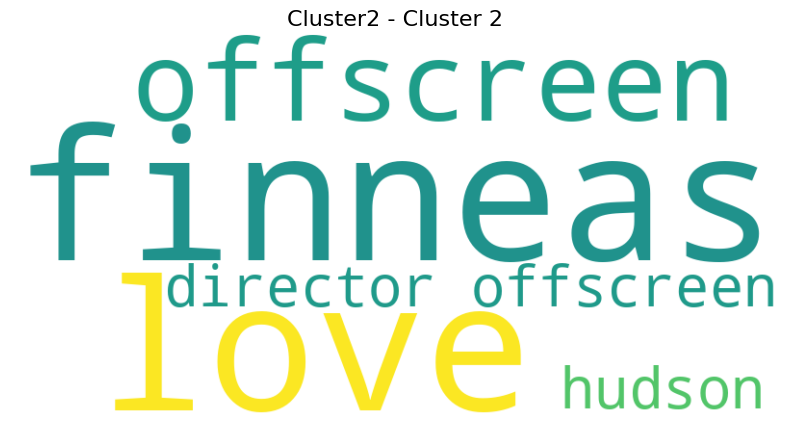

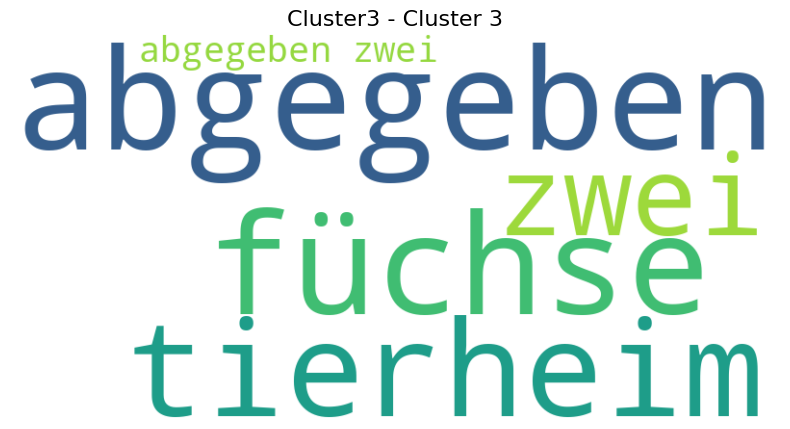

In [ ]:
for i in range(k):
  top_terms = cluster_labels[i]['top_terms']
  freq_dict = {term: 1 for term in top_terms} #equal weifhting for word cloud

  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

  plt.figure(figsize=(10,5))
  plt.imshow(wordcloud,interpolation='bilinear')
  plt.axis("off")
  label = cluster_labels[i]['custom_label'] if 'custom_label' in cluster_labels[i] else f"Cluster {i}"
  plt.title(f"Cluster{i} - {label}", fontsize = 16)
  plt.show()

<ipython-input-14-a5398432b466>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(key='date', freq="M"),
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transf

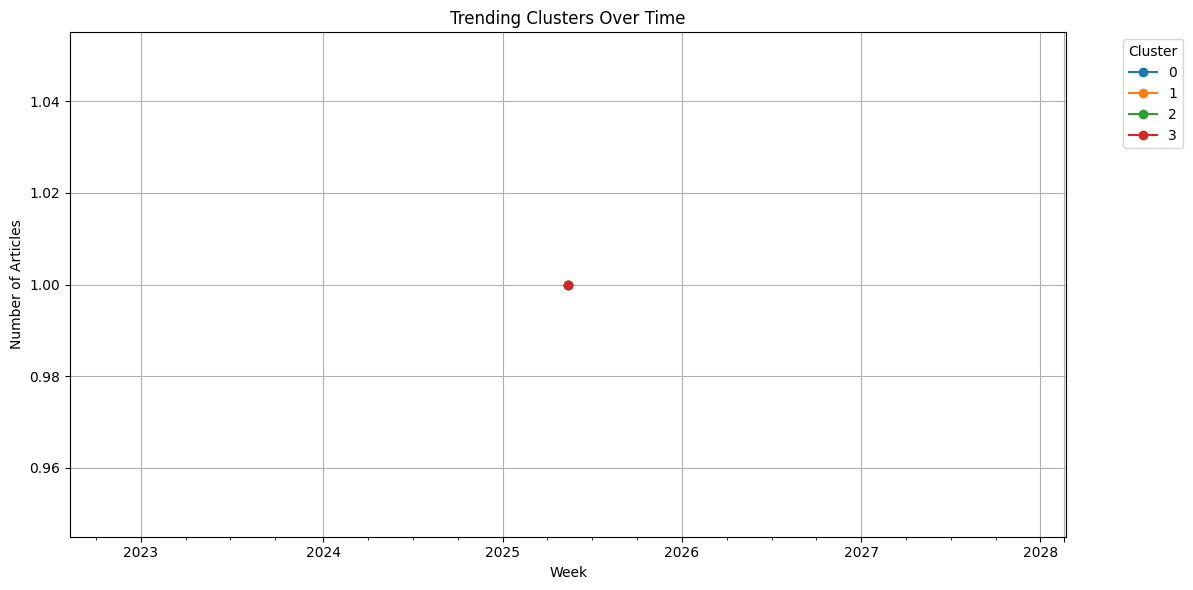

In [ ]:
#Trending Clusters over Time

article_cluster_counts = []

for article in final_articles:
  cluster = article['cluster'] if 'cluster' in article else -1

  article_cluster_counts.append({
      'date': article.get('publishedAt', '')[:10],
      'cluster': cluster
  })

cluster_df = pd.DataFrame(article_cluster_counts)

cluster_df['date'] =  pd.to_datetime(cluster_df['date'])

monthly_counts = cluster_df.groupby([
    pd.Grouper(key='date', freq="M"),
    'cluster'
]).size().unstack(fill_value=0)

weekly_counts = cluster_df.groupby([
    pd.Grouper(key='date', freq="W"), #weekly bins
    "cluster"
]).size().unstack(fill_value=0)

weekly_counts.tail() #Views latest week

#Plotting weekly time trends

weekly_counts.plot(figsize=(12,6), kind='line', marker='o')
plt.title("Trending Clusters Over Time")
plt.xlabel("Week")
plt.ylabel("Number of Articles")
plt.legend(title="Cluster", bbox_to_anchor =(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


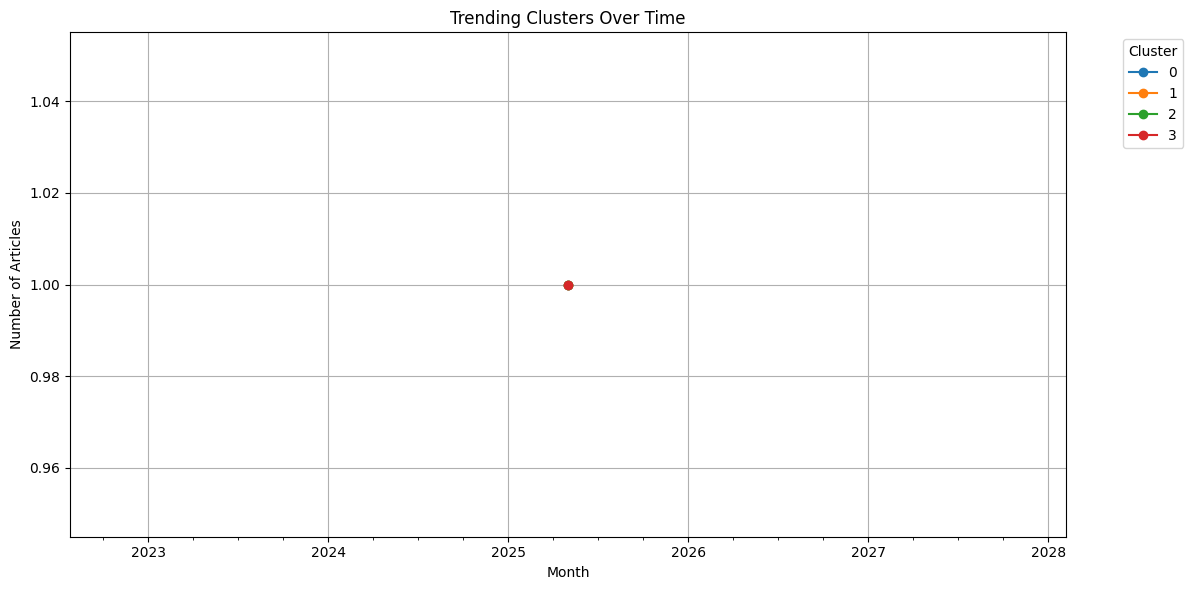

In [ ]:
#Plotting monthly time trends

weekly_counts.columns = [
    cluster_labels[col]['custom_label'] if col in cluster_labels else f"Cluster {col}"
    for col in monthly_counts.columns
]

monthly_counts.plot(figsize=(12,6), kind='line', marker='o')
plt.title("Trending Clusters Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.legend(title="Cluster", bbox_to_anchor =(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def save_trends_to_csv(weekly_df, monthly_df, cluster_labels, output_dir='trend_exports'):
  #Create folder if it doesn't exist
  os.makedirs(output_dir, exist_ok=True)

  #Save weekly & monthly counts
  weekly_df.to_csv(f"{output_dir}/weekly_trends.csv")
  monthly_df.to_csv(f"{output_dir}/monthly_trends.csv")

  #Save cluster label summaries
  label_data = []
  for cluster_id, info in cluster_labels.items():
    label_data.append({
        "cluster_id": cluster_id,
        "custom_label": info.get("custom_label", f"Cluster {cluster_id}"),
        "top_terms": ", ".join(info["top_terms"])
    })
    label_df = pd.DataFrame(label_data)
    label_df.to_csv(f"{output_dir}/cluster_labels.csv", index=False)

    print(f"Trend data saved to '{output_dir}/' folder.")

In [ ]:
latest_week = weekly_counts.tail(1)

top_clusters = latest_week.T.sort_values(by=latest_week.index[-1], ascending=False).head(3)

print("This Week's Top Topics:\n")

for i, (cluster_name, count) in enumerate(top_clusters.itertuples(), start=1):
  medal = {1: "🥇", 2: "🥈", 3: "🥉"}.get(i, f"{i}")
  print(f"{medal} {cluster_name}({count} articles)")

This Week's Top Topics:

🥇 Cluster 0(1 articles)
🥈 Cluster 1(1 articles)
🥉 Cluster 2(1 articles)


In [ ]:
latest_month = monthly_counts.tail(1)

top_month_clusters = latest_month.T.sort_values(by=latest_month.index[-1], ascending=False).head(3)

print("This Month's Top Topics:\n")

for i, (cluster_name, count) in enumerate(top_month_clusters.itertuples(), start=1):
  medal = {1: "🥇", 2: "🥈", 3: "🥉"}.get(i, f"{i}")
  print(f"{medal} {cluster_name}({count} articles)")

save_trends_to_csv(weekly_counts, monthly_counts, cluster_labels)

This Month's Top Topics:

🥇 0(1 articles)
🥈 1(1 articles)
🥉 2(1 articles)
Trend data saved to 'trend_exports/' folder.
Trend data saved to 'trend_exports/' folder.
Trend data saved to 'trend_exports/' folder.
Trend data saved to 'trend_exports/' folder.
